# Pool Elo

In [241]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import csv
from datetime import datetime

# Elo 

In [365]:
# Read Test Dataset 
data = pd.read_csv('data/predatorCLPClean.csv')
data['date'] = pd.to_datetime(data['date'])
fulldf = pd.read_csv("data/fulldf.csv")
fulldf['date'] = pd.to_datetime(fulldf['date'])


In [385]:
data

,Unnamed: 0,matchIndex,playerA,playerB,playerARacks,playerBRacks,playerARacks.1,date,competition
0,0,1,Chris Melling,Ralf Souquet,5,0,5,2021-03-22,2021 Predator CLP
1,1,2,Albin Ouschan,Chris Robinson,5,2,5,2021-03-22,2021 Predator CLP
2,2,3,Kelly Fisher,Niels Feijen,5,4,5,2021-03-22,2021 Predator CLP
3,3,4,Eklent Kaci,Albin Ouschan,5,4,5,2021-03-22,2021 Predator CLP
4,4,5,Niels Feijen,Chris Robinson,5,3,5,2021-03-22,2021 Predator CLP
...,...,...,...,...,...,...,...,...,...
187,187,188,Albin Ouschan,Niels Feijen,5,4,5,2021-03-29,2021 Predator CLP
188,188,189,Naoyuki Oi,David Alcaide,5,4,5,2021-03-29,2021 Predator CLP
189,189,190,Albin Ouschan,Eklent Kaci,5,2,5,2021-03-29,2021 Predator CLP
190,190,191,David Alcaide,Chris Melling,5,2,5,2021-03-29,2021 Predator CLP


In [366]:
# Elo Rating System 
# Constants
INITIAL_RATING = 1500
ELO_WIDTH = 400
K = 50

players = pd.concat([fulldf.playerA, fulldf.playerB] )
print(players.value_counts().index.unique())
# How many players
nplayers = len(players.value_counts())
nplayers

Index(['Shane Van Boening', 'Darren Appleton', 'Niels Feijen',
       'Dennis Orcollo', 'Jayson Shaw', 'Ralf Souquet', 'Alex Pagulayan',
       'Ko Pin Yi', 'Thorsten Hohmann', 'Albin Ouschan',
       ...
       'Takashi Uraoka', 'Maxwell Johnson', 'Marlon Caneda', 'Le Quang Trun',
       'Angel Gabriel Acosta', 'Stephen Webber', 'Raed Shabib', 'Martin Wragg',
       'Mike Davis', 'Keith Yip'],
      dtype='object', length=941)


941

In [367]:

def expected(A, B, elo_width): 
    proba = 1/ ( 1 + 10 ** ((B - A) / elo_width))
    return( proba )

# https://www.kaggle.com/kplauritzen/elo-ratings-in-python
def update_elo(winner_elo, loser_elo, k, elo_width):
    expected_win = expected(winner_elo, loser_elo, elo_width)
    change_in_elo = k * (1-expected_win)
    winner_elo += change_in_elo
    loser_elo -= change_in_elo
    return winner_elo, loser_elo

def run_tournament3(data=data, INITIAL_RATING = INITIAL_RATING, ELO_WIDTH = ELO_WIDTH, K=K):
    
    # Initialize Elo Ratings
    elo_ratings = dict(zip(players.value_counts().index.unique(), 
                           np.repeat(INITIAL_RATING, nplayers)) )

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        if row['playerARacks'] > row['playerBRacks']: 
            winner = row["playerA"]
            loser = row["playerB"]
        else: 
            winner = row['playerB']
            loser = row['playerA']
        new_winner_rating, new_loser_rating = update_elo(elo_ratings[winner], elo_ratings[loser], K, ELO_WIDTH)
        elo_ratings[winner] = new_winner_rating
        elo_ratings[loser] = new_loser_rating
    ratings = pd.DataFrame.from_dict(elo_ratings, orient='index')
    ratings = ratings.rename(columns={0: "ratings"})
    return(ratings)

In [368]:
ratings = run_tournament3(fulldf)

In [369]:
ratings
ratings.sort_values(by='ratings', ascending = False)[0:25]


,ratings
Jayson Shaw,1930.092641
Eklent Kaci,1788.286235
Niels Feijen,1787.672023
Liu Haitao,1777.264924
Albin Ouschan,1768.221685
Joshua Filler,1767.256092
Fedor Gorst,1765.414498
Maximilian Lechner,1752.736808
Jeffrey de Luna,1745.968700
Francisco Sanchez Ruiz,1738.593695


In [370]:
playersCLP = pd.concat([data.playerA, data.playerB] )


In [371]:
# Get correct players
playersindex = []
names = []
for player in playersCLP.unique():
    if player in ratings.index:
        playersindex.append(np.where(players.value_counts().index == player)[0][0])
        names.append(np.where(ratings.index == player)[0][0])
playersindex
names

[19, 9, 745, 22, 2, 5, 292, 36, 12, 1, 78, 24, 896, 93, 97, 13, 89, 42, 385]

In [372]:
# Games in the prior dataset
players.value_counts()[playersindex]
fullPlayerList = list(players.value_counts()[playersindex].index)
print(fullPlayerList)
# fullPlayerList.append("Kristina Tkach")
# fullPlayerList.append("Kelly Fisher")

CLPratings = ratings.iloc[np.array(names)]
print(CLPratings)
# CLPratings = CLPratings.append([{"ratings": 1500}], ignore_index = True)

CLPratings = CLPratings.set_index(pd.Index(fullPlayerList) )

['Chris Melling', 'Albin Ouschan', 'Kelly Fisher', 'Eklent Kaci', 'Niels Feijen', 'Ralf Souquet', 'Chris Robinson', 'Mieszko Fortunski', 'David Alcaide', 'Darren Appleton', 'Billy Thorpe', 'Naoyuki Oi', 'Kristina Tkach', 'Roberto Gomez', 'Marc Bijsterbosch', 'Alex Kazakis', 'Casper Matikainen', 'Denis Grabe', 'Jasmin Ouschan']
                       ratings
Chris Melling      1521.169700
Albin Ouschan      1768.221685
Kelly Fisher       1480.158376
Eklent Kaci        1788.286235
Niels Feijen       1787.672023
Ralf Souquet       1672.400418
Chris Robinson     1499.785064
Mieszko Fortunski  1729.461841
David Alcaide      1709.462142
Darren Appleton    1601.197667
Billy Thorpe       1605.025430
Naoyuki Oi         1622.121772
Kristina Tkach     1473.201280
Roberto Gomez      1429.652092
Marc Bijsterbosch  1437.416879
Alex Kazakis       1694.974797
Casper Matikainen  1627.807065
Denis Grabe        1523.007613
Jasmin Ouschan     1500.025918


In [373]:
CLPratings.sort_values(by = "ratings", ascending = False)

,ratings
Eklent Kaci,1788.286235
Niels Feijen,1787.672023
Albin Ouschan,1768.221685
Mieszko Fortunski,1729.461841
David Alcaide,1709.462142
Alex Kazakis,1694.974797
Ralf Souquet,1672.400418
Casper Matikainen,1627.807065
Naoyuki Oi,1622.121772
Billy Thorpe,1605.025430


In [374]:

def expected(A, B, elo_width): 
    proba = 1/ ( 1 + 10 ** ((B - A) / elo_width))
    return( proba )

# https://www.kaggle.com/kplauritzen/elo-ratings-in-python
def update_elo(winner_elo, loser_elo, k, elo_width):
    """
    https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
    """
    expected_win = expected(winner_elo, loser_elo, elo_width)
    change_in_elo = k * (1-expected_win)
    winner_elo += change_in_elo
    loser_elo -= change_in_elo
    return winner_elo, loser_elo

import math

def get_loglikelihood(newdata, ratings, ELO_WIDTH = ELO_WIDTH):

    loglikelihood = 0
    # Iterate through rows of dataframe 
    for index, row in newdata.iterrows():
        if row['playerARacks'] > row['playerBRacks']: 
            winner = row["playerA"]
            loser = row["playerB"]
        else: 
            winner = row['playerB']
            loser = row['playerA']
        winnerrating = ratings.loc[winner]
        loserrating = ratings.loc[loser]
        proba = expected(winnerrating, loserrating, ELO_WIDTH)   
        
    
        loglikelihood += math.log(proba)

        
    return(loglikelihood)

In [375]:
get_loglikelihood(data, CLPratings)

-135.04493447368495

In [376]:
data

,Unnamed: 0,matchIndex,playerA,playerB,playerARacks,playerBRacks,playerARacks.1,date,competition
0,0,1,Chris Melling,Ralf Souquet,5,0,5,2021-03-22,2021 Predator CLP
1,1,2,Albin Ouschan,Chris Robinson,5,2,5,2021-03-22,2021 Predator CLP
2,2,3,Kelly Fisher,Niels Feijen,5,4,5,2021-03-22,2021 Predator CLP
3,3,4,Eklent Kaci,Albin Ouschan,5,4,5,2021-03-22,2021 Predator CLP
4,4,5,Niels Feijen,Chris Robinson,5,3,5,2021-03-22,2021 Predator CLP
...,...,...,...,...,...,...,...,...,...
187,187,188,Albin Ouschan,Niels Feijen,5,4,5,2021-03-29,2021 Predator CLP
188,188,189,Naoyuki Oi,David Alcaide,5,4,5,2021-03-29,2021 Predator CLP
189,189,190,Albin Ouschan,Eklent Kaci,5,2,5,2021-03-29,2021 Predator CLP
190,190,191,David Alcaide,Chris Melling,5,2,5,2021-03-29,2021 Predator CLP


# Tuning K

In [378]:
K = np.arange(1, 101, 1)

In [379]:
log_likelihoods = []
for k in K: 
    # Get ratings 
    allratings = run_tournament3(fulldf, K=k)
    
    # Filter ratings 
    CLPratings = allratings.iloc[np.array(names)]
#     CLPratings = CLPratings.append([{"ratings": 1500}], ignore_index = True)
    CLPratings = CLPratings.set_index(pd.Index(fullPlayerList) )
    
    log_likelihoods.append(get_loglikelihood(data, CLPratings))

Optimal K is 14


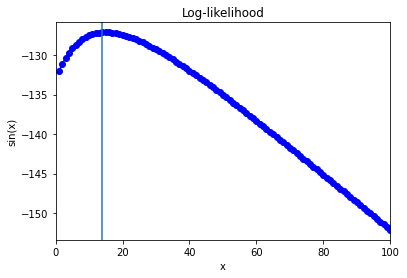

In [380]:
ax = plt.axes()
ax.plot(K, log_likelihoods, '--bo')
ax.axvline(log_likelihoods.index(max(log_likelihoods)))
ax.set(xlim=(0, 100),
       xlabel='x', ylabel='sin(x)',
       title='Log-likelihood');

print("Optimal K is " + str(log_likelihoods.index(max(log_likelihoods))))

In [381]:
bestK = log_likelihoods.index(max(log_likelihoods))

In [383]:
# Get ratings 
allratings = run_tournament3(fulldf, K=bestK)
allratings.sort_values(by='ratings', ascending = False)[0:25]


,ratings
Jayson Shaw,1683.028223
Shane Van Boening,1651.630984
Albin Ouschan,1645.918810
Niels Feijen,1632.536318
Carlo Biado,1616.925570
Joshua Filler,1616.574936
Eklent Kaci,1616.205997
Dennis Orcollo,1613.777902
Liu Haitao,1608.724661
Ko Ping-Chung,1607.757178


In [384]:
# Filter ratings 
CLPratings = allratings.iloc[np.array(names)]
# CLPratings = CLPratings.append([{"ratings": 1500}], ignore_index = True)
CLPratings = CLPratings.set_index(pd.Index(fullPlayerList) )
CLPratings.sort_values(by='ratings', ascending = False)

,ratings
Albin Ouschan,1645.918810
Niels Feijen,1632.536318
Eklent Kaci,1616.205997
David Alcaide,1598.318801
Alex Kazakis,1584.178005
Mieszko Fortunski,1579.089387
Ralf Souquet,1571.277488
Darren Appleton,1556.091696
Naoyuki Oi,1539.747752
Casper Matikainen,1538.157057


# Update Posterior Ratings after Predator CLP

In [317]:

def run_tournament_with_prior_ratings(data, priorratings, ELO_WIDTH = ELO_WIDTH, K=bestK):
    

    # Initialize Elo Ratings
    elo_ratings = priorratings

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        if row['playerARacks'] > row['playerBRacks']: 
            winner = row["playerA"]
            loser = row["playerB"]
        else: 
            winner = row['playerB']
            loser = row['playerA']
        k=K
#         if row['isSemi'] == True: 
#             k = K*2
#         elif row['isFinal'] == True: 
#             k = K*3
#         else: 
#             k = K
        new_winner_rating, new_loser_rating = update_elo(elo_ratings.loc[winner][0], elo_ratings.loc[loser][0], k, ELO_WIDTH)
        elo_ratings.loc[winner][0] = new_winner_rating
        elo_ratings.loc[loser][0] = new_loser_rating
    return(elo_ratings)

In [318]:
posterior_ratings = run_tournament_with_prior_ratings(data, priorratings = CLPratings)

In [319]:
posterior_ratings.sort_values(by = "ratings", ascending = False)

,ratings
Eklent Kaci,1681.808890
Albin Ouschan,1680.261770
David Alcaide,1664.224258
Niels Feijen,1636.157196
Alex Kazakis,1608.697010
Chris Melling,1584.158841
Naoyuki Oi,1575.888423
Mieszko Fortunski,1542.982168
Darren Appleton,1541.004199
Ralf Souquet,1539.958227


In [ ]:
# Things to Extend 
    # Figure out how to extend K 
        # K varying as a function of scoreline
    # Glicko 
        
    # Data collection 


# Sandbox Code 

In [70]:
# Elo Rating System 
# Constants
INITIAL_RATING = 1500
ELO_WIDTH = 400
K = 50

In [69]:
def expected(A, B, elo_width): 
    proba = 1/ ( 1 + 10 ** ((B - A) / elo_width))
    return( proba )

# https://www.kaggle.com/kplauritzen/elo-ratings-in-python
def update_elo(winner_elo, loser_elo, k, elo_width):
    """
    https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
    """
    expected_win = expected(winner_elo, loser_elo, elo_width)
    change_in_elo = k * (1-expected_win)
    winner_elo += change_in_elo
    loser_elo -= change_in_elo
    return winner_elo, loser_elo

In [98]:

def run_tournament(data=data, INITIAL_RATING = INITIAL_RATING, ELO_WIDTH = ELO_WIDTH, k=K):
    
    # Initialize Elo Ratings
    elo_ratings = dict(zip(players.value_counts().index.unique(), 
                           np.repeat(INITIAL_RATING, nplayers)) )

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        winner = row["WinnerName"]
        loser = row["LoserName"]
        if row['isSemi'] == True: 
            k = K*2
        elif row['isFinal'] == True: 
            k = K*3
        else: 
            k = K
        new_winner_rating, new_loser_rating = update_elo(elo_ratings[winner], elo_ratings[loser], k, ELO_WIDTH)
        elo_ratings[winner] = new_winner_rating
        elo_ratings[loser] = new_loser_rating
    ratings = pd.DataFrame.from_dict(elo_ratings, orient='index')
    ratings = ratings.rename(columns={0: "ratings"})
    return(ratings)

In [99]:
ratings = run_tournament()

KeyError: 'Kelly Fisher'

In [100]:
ratings.sort_values(by='ratings', ascending = False)

,ratings
Shannon Murphy,1475.0
Robby Foldvari,1475.0
Jang Moonseok,1475.0
Francois Ellis,1475.0
Himanshu Jain,1475.0
...,...
Albin Ouschan,800.0
Jayson Shaw,775.0
Alex Pagulayan,750.0
Dennis Orcollo,750.0


In [101]:
# Train-Test Split
winnersgroup = data[data.Group == 8]
prelims = data[data.Group != 8]

In [102]:
ratingsPrelims = run_tournament(data=prelims)

KeyError: 'Kelly Fisher'

In [103]:
ratingsPrelims
ratingsPrelims.sort_values(by='ratings', ascending = False)


NameError: name 'ratingsPrelims' is not defined